In [1]:
import sys
sys.path.append('..')
from ddn_config import *
from ddn_etl_utils import *
from etl_es import *
import datetime
import hashlib

from pyspark.sql.types import *
from pyspark.sql import Row

In [2]:
start_time = '2018-07-27 19:05:00'
end_time = '2018-07-27 19:20:59'

read_label = True

In [3]:
def vpn_ip(ip):
    if '172.' in ip:
        return True
    return False
vpn_ip_udf = udf(vpn_ip, BooleanType())

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
node_schema = ['type', 'node_id', 'node_ip', 'node_attr', 'ddn_id']
edge_schema = ['from_id', 'to_id', 'proto', 'ddn_id', 'application', 'direction', 'total_bytes']

# the schema for matching labels with existing ddn
# category supports : 1. user; 2. application
# role: will be used as ddn id
# ids: for user, this list is ip list, for application, this list will be application key works within URI
label_schema = ['category', 'role', 'ids']

web_portal = ['192.168.7.100', '192.168.8.100']
sql_portal = ['192.168.8.74', '192.168.8.155']

#TODO: figure out an algorithm to detect multi-homed machines
multi_homed_machine = [['192.168.7.100', 
                        '192.168.8.100']]

In [6]:
multi_homed_machine_dict = {'192.168.7.100': 'web',
                            '192.168.8.100': 'web'}
rows = []
for ip in web_portal:
    row_dict = {}
    row_dict['type'] = 'application'
    row_dict['node_id'] = multi_homed_machine_dict[ip]
    row_dict['node_ip'] = ip
    row_dict['node_attr'] = ' '
    row_dict['ddn_id'] = 'default_pii'
    rows.append(Row(**row_dict))
sc = spark.sparkContext
web_nodes = sc.parallelize(rows).toDF().select(node_schema)

In [7]:
interested_ip = web_portal + sql_portal
interested_ip
def in_list(ip):
    return ip in interested_ip
in_list_udf = udf(in_list, BooleanType())

def multihomed_ip(ip):
    for machine in multi_homed_machine:
        if ip in machine:
            return ','.join(machine)
    return None
multihomed_ip_udf = udf(multihomed_ip, StringType())

def filter_intenal_ip(ip):
    if ip is None:
        return False
    return '192.168' in ip
filter_internal_ip_udf = udf(filter_intenal_ip, BooleanType())

In [8]:
time_resolution = 300 # in secs, 5min
def float_to_datetime(seconds):
    if seconds is None:
        return 0.0
    return float(seconds)
sec_to_dt_udf = udf(float_to_datetime, DoubleType())

def ts_to_float(str):
    from dateutil.parser import parse
    if str is None:
        return 0.0
    dt = parse(str)
    return dt.timestamp()
ts_to_float_udf = udf(ts_to_float, DoubleType())
    

In [9]:
start_time = '2018-07-27 19:05:00'
end_time = '2018-07-27 19:20:59'
ddn = connect_ddn(start_time = start_time, 
                  end_time = end_time)
ddn = ddn.filter(col('app')!='dns')\
         .repartition(8)
from_ddn = ddn.filter(in_list_udf("`id.orig_h`"))
to_ddn = ddn.filter(in_list_udf("`id.resp_h`"))
interested_ddn = from_ddn.union(to_ddn)\
                         .withColumn('ts_float', ts_to_float_udf('@timestamp'))\
                         .persist()

GET http://192.168.7.25:9200/tds/_search?size=10000 [status:404 request:0.010s]
GET http://192.168.7.25:9200/tds_sqlbatch/_search?size=10000 [status:404 request:0.004s]
GET http://192.168.7.25:9200/tds_tds7login/_search?size=10000 [status:404 request:0.004s]


Reading index tds error from ES
Reading index tds_sqlbatch error from ES
Reading index tds_tds7login error from ES
Reading index fuzzy error from ES


AnalysisException: "cannot resolve '`sha1`' given input columns: [container, @version, parent, filename, hash, @timestamp];;\n'Project [container#697, filename#698, hash#699, 'sha1]\n+- AnalysisBarrier\n      +- Project [_source#688.@timestamp AS @timestamp#695, _source#688.@version AS @version#696, _source#688.container AS container#697, _source#688.filename AS filename#698, _source#688.hash AS hash#699, _source#688.parent AS parent#700]\n         +- LogicalRDD [_id#685, _index#686, _score#687, _source#688, _type#689], false\n"

In [10]:
connection_schema = ['`id.orig_h`', '`id.orig_p`', '`id.resp_h`', '`id.resp_p`', '@timestamp', 
                     'ts_float', 'app', 'sqlbatch', 'arg', 'cmd', 'uri', 'proto', 'method', 
                     'orig_bytes', 'resp_bytes', 'uid', 'orig_sum_bytes', 'resp_sum_bytes']
interested_ddn.distinct().count()

# this will be used to derive "edge"
all_connections = interested_ddn.select(connection_schema).distinct()

In [11]:

# the following block calculate db host, talbes, and column names
SQL_COL = 'sql_query' # when sqlbatch works, update here
def fill_sql_query(sqlbatch, arg):
    if sqlbatch is None:
        return arg
    return sqlbatch
fill_sql_query_udf = udf(fill_sql_query, StringType())

def extract_table_column_sql(row):
    sql = row[SQL_COL]
    host = row['id.resp_h']   
    key = host
    table = ''
    columns = []
    if sql is None:
        return (key, columns)
    sql = sql.lower()
    from_split = sql.split('from ')
    if len(from_split) == 2:
        where_split = from_split[1].split(' where ')
        col_split = where_split[1].split(' =')
        # tables.append(where_split[0])
        table = where_split[0]
        columns.append(col_split[0])
    insert_split = sql.split('insert into ')
    if len(insert_split) == 2:
        #tables.append(insert_split[1].split(' ')[0])
        table = insert_split[1].split(' ')[0]
        columns.append('*') # all columns
    return (key + ';' + table, columns)

def gen_direction(sql, method):
    if sql is not None:
        sql = sql.lower()
        if 'insert into' in sql:
            return 'co'
        if 'select' in sql:
            return 'counter'
    if method is not None:
        method = method.lower()
        if 'post' in method:
            return 'co'
        if 'get' in method:
            return 'counter'
    return None
gen_direction_udf = udf(gen_direction, StringType())

def gen_total_bytes(direction, orig_sum_bytes, resp_sum_bytes):
    if orig_sum_bytes is None:
        orig_sum_bytes = 0.0
    if resp_sum_bytes is None:
        resp_sum_bytes = 0.0
    def _my_max(a, b):
        if a >= b:
            return a
        return b
    if direction is None:
        return _my_max(orig_sum_bytes, resp_sum_bytes)
    if direction == 'co':
        return orig_sum_bytes
    return resp_sum_bytes
gen_total_bytes_udf = udf(gen_total_bytes, DoubleType())

def combine_tables(x, y):
    columns = set()
    columns.update(x)
    columns.update(y)
    return list(columns)

def process_table_col_to_row(pair):
    host_table = pair[0]
    tokens = host_table.split(';')
    host = tokens[0]
    table_name = None
    if len(tokens) == 2:
        table_name = tokens[1]
    columns = pair[1]
    
    res = {}
    res['db_host'] = host
    res['tables'] = table_name
    res['columns'] = columns
    return Row(**res)
    
all_connections = all_connections.withColumn(SQL_COL, fill_sql_query_udf('sqlbatch', 'arg'))\
                                 .withColumn('direction', gen_direction_udf(SQL_COL, 'method'))\
                                 .withColumn('total_bytes', gen_total_bytes_udf('direction', 'orig_sum_bytes', 'resp_sum_bytes'))
db_table_col = all_connections.filter(col(SQL_COL).isNotNull())\
                           .rdd.map(lambda row: extract_table_column_sql(row))\
                           .reduceByKey(lambda x, y: combine_tables(x, y))\
                           .map(lambda pair: process_table_col_to_row(pair))\
                           .toDF()\
                           .filter(col('tables')!='')

In [12]:
# Calculate db node
db_map = {
    '192.168.8.74' : 'mysql',
    '192.168.8.155': 'mssql'
    }
def generate_db_id(ip):
    return db_map.get(ip)
generate_db_id_udf = udf(generate_db_id, StringType())

def generate_db_ip(ip):
    return ip
generate_db_ip_udf = udf(generate_db_ip, StringType())

def generate_db_attr(columns, tables):
    res = {}
    res['columns'] = columns
    res['tables'] = tables
    return json.dumps(res)
generate_db_attr_udf = udf(generate_db_attr, StringType())

# node_schema = ['type', 'node_id', 'node_ip', 'node_attr', 'ddn_id']
db_inter_df = db_table_col.withColumn('type', lit('database'))\
                        .withColumn('node_id', generate_db_id_udf('db_host'))\
                        .withColumn('node_ip', generate_db_ip_udf('db_host'))\
                        .withColumn('node_attr', generate_db_attr_udf('columns', 'tables'))\
                        .withColumn('ddn_id', lit('default_pii'))
db_node = db_inter_df.select(node_schema)

In [13]:
db_node.show()

+--------+-------+-------------+--------------------+-----------+
|    type|node_id|      node_ip|           node_attr|     ddn_id|
+--------+-------+-------------+--------------------+-----------+
|database|  mssql|192.168.8.155|{"columns": ["eid...|default_pii|
|database|  mssql|192.168.8.155|{"columns": ["eid...|default_pii|
|database|  mysql| 192.168.8.74|{"columns": ["*",...|default_pii|
|database|  mysql| 192.168.8.74|{"columns": ["eid...|default_pii|
|database|  mssql|192.168.8.155|{"columns": ["eid...|default_pii|
+--------+-------+-------------+--------------------+-----------+



In [289]:
table_nodes = db_inter_df.drop('node_id')\
                        .withColumn('type', lit('table'))\
                       .withColumn('node_id', col('tables'))\
                       .select(node_schema)
# ['from_id', 'to_id', 'proto', 'ddn_id', 'application', 'direction', 'total_bytes']
table_edges = db_inter_df.withColumn('from_id', col('node_ip'))\
                        .withColumn('to_id', col('tables'))\
                        .withColumn('proto', lit('same_machine'))\
                        .withColumn('ddn_id', lit('default_pii'))\
                        .withColumn('application', lit(''))\
                        .withColumn('direction', lit('co'))\
                        .withColumn('total_bytes', lit(0))\
                        .select(edge_schema)

In [201]:
table_nodes.show()

+-----+-----------+-------------+--------------------+-----------+
| type|    node_id|      node_ip|           node_attr|     ddn_id|
+-----+-----------+-------------+--------------------+-----------+
|table|   employee|192.168.8.155|{"columns": ["eid...|default_pii|
|table|performance|192.168.8.155|{"columns": ["eid...|default_pii|
|table|  customers| 192.168.8.74|{"columns": ["*",...|default_pii|
|table|      sales| 192.168.8.74|{"columns": ["eid...|default_pii|
|table|    payment|192.168.8.155|{"columns": ["eid...|default_pii|
+-----+-----------+-------------+--------------------+-----------+



In [202]:
# the following block extracts application information
application_cols = ['`id.orig_h`', '`id.orig_p`', '`id.resp_h`', '`id.resp_p`', 'application', 'proto', 'direction', 'total_bytes']
known_applications = ['payroll', 'employee_info', 'customer', 'performance', 'sales']
def extract_application_from_uri(uri):
    if uri is None \
        or uri == '/' \
        or not uri.startswith('/'):
        return 'unknown'
    for known_app in known_applications:
        if known_app in uri:
            return known_app + "_app"
    return 'unknown'
#     tokens = uri.split('/')
#     return tokens[1]
application_udf = udf(extract_application_from_uri, StringType())

def get_app_direction_from_uri(uri, direction):
    if uri is None:
        return None
    if 'set' in uri:
        return 'co'
    if 'check' in uri:
        return 'counter'
    return direction
get_app_direction_from_uri_udf = udf(get_app_direction_from_uri, StringType())

def in_web_list(ip):
    return ip in web_portal
in_web_list_udf = udf(in_web_list, BooleanType())

def in_sql_list(ip):
    return ip in sql_portal
in_sql_list_udf = udf(in_sql_list, BooleanType())

user_to_app = all_connections.filter(in_web_list_udf('`id.resp_h`'))\
                                 .withColumn('application', application_udf('uri'))\
                                 .withColumn('direction', get_app_direction_from_uri_udf('uri', 'direction'))\
                                 .select(application_cols)\
                                 .distinct().filter(col('application')!='unknown')

In [203]:
def app_gen_from_id(from_ip, port, application):
    return application # from_ip + ":" + port + '/' +
app_gen_from_id_udf = udf(app_gen_from_id, StringType())

# currently this is a placeholder
def generate_app_attr(ip):
    res = {}
    res['ip'] = ip
    return json.dumps(res)
generate_app_attr_udf = udf(generate_app_attr, StringType())

app_node = user_to_app.withColumn('type', lit('application'))\
                      .withColumn('node_id', app_gen_from_id_udf('`id.resp_h`', '`id.resp_p`', 'application'))\
                      .withColumn('node_ip', col('`id.resp_h`'))\
                      .withColumn('node_attr', generate_app_attr_udf('`id.resp_h`'))\
                      .withColumn('ddn_id', lit('default_pii'))\
                      .select(node_schema)\
                      .distinct()

In [205]:
# calculate app to storage edge

def app_gen_from_id(from_ip, port, application):
    return from_ip# + ":" + port + '/' + application
app_gen_from_id_udf = udf(app_gen_from_id, StringType())

def app_gen_to_id(orig_ip):
    return orig_ip
app_gen_to_id_udf = udf(app_gen_to_id, StringType())

def gen_proto_port(port, proto):
    return proto+":"+port
gen_proto_port_udf = udf(gen_proto_port, StringType())

# # this is a placeholder for application edge.
# # currently it does NOT add any information
# def app_gen_edge_attr(port, proto, total_bytes):
#     res = {}
#     res['port'] = port
#     res['protocol'] = proto
#     res['total_bytes'] = total_bytes
#     return json.dumps(res)
# app_gen_edge_attr_udf = udf(app_gen_edge_attr, StringType())

app_to_db = all_connections.filter(in_sql_list_udf('`id.resp_h`'))\
                                 .withColumn('application', application_udf('uri'))\
                                 .select(application_cols)\
                                 .distinct()
app_edge = app_to_db.withColumn('from_id', app_gen_from_id_udf('`id.orig_h`','`id.resp_p`','application'))\
                   .withColumn('to_id', app_gen_to_id_udf('`id.resp_h`'))\
                   .withColumn('ddn_id', lit('default_pii'))\
                   .select(edge_schema)\
                   .distinct()



In [207]:
# the following block add user information to all the connections
# known_users = {
#     '192.168.7.130' : 'arthur',
#     '192.168.7.171' : 'hua'
# }
def add_user(ip):
    return ip
#     if ip in known_users:
#         return known_users[ip]
#     return 'unknown'
add_user_udf = udf(add_user, StringType())
all_connections_with_app = all_connections.withColumn('application', application_udf('uri'))
user_df = all_connections_with_app.withColumn('user', add_user_udf('`id.orig_h`'))\
                                  .filter(~in_list_udf('`id.orig_h`'))
#                         .filter(col('user')!='unknown')

In [208]:
def generate_user_attr(ip, username):
    res = {}
    res['ip'] = ip
    res['username'] = username
    return json.dumps(res)
generate_user_attr_udf = udf(generate_user_attr, StringType())

user_node = user_df.withColumn('type', lit('user'))\
              .withColumn('node_id', col('user'))\
              .withColumn('node_ip', col('`id.orig_h`'))\
              .withColumn('node_attr', generate_user_attr_udf('`id.orig_h`', 'user'))\
              .withColumn('ddn_id', lit('default_pii'))\
              .select(node_schema).distinct()

In [209]:
def user_gen_from_id(orig_ip):
    return orig_ip
user_gen_from_id_udf = udf(user_gen_from_id, StringType())

def user_gen_to_id(resp_ip, port, application):
    if application is not None and application != 'unknown':
        return application #resp_ip + ":" + port + '/' + 
    return resp_ip
user_gen_to_id_udf = udf(user_gen_to_id, StringType())

# # this is a placeholder for user to application edge.
# # currently it does NOT add any information
# def user_gen_edge_attr(port, proto, total_bytes):
#     res = {}
#     ports = set()
#     ports.add(port)
    
#     protos = set()
#     protos.add(proto)
    
#     res['port'] = ports
#     res['protocol'] = protos
#     res['total_bytes'] = total_bytes
#     return json.dumps(res)
# user_gen_edge_attr_udf = udf(user_gen_edge_attr, StringType())

user_edge = user_df.withColumn('from_id', user_gen_from_id_udf('`id.orig_h`'))\
                   .withColumn('to_id', user_gen_to_id_udf('`id.resp_h`','`id.resp_p`','application'))\
                   .withColumn('ddn_id', lit('default_pii'))\
                   .select(edge_schema)



In [210]:
nodes = app_node.union(user_node)\
                .union(db_node)\
                .union(web_nodes)\
                .union(table_nodes)\
                .withColumn('multi_home', multihomed_ip_udf('node_ip'))

In [288]:
table_nodes.show()

+--------+-----------+-------------+--------------------+-----------+
|    type|    node_id|      node_ip|           node_attr|     ddn_id|
+--------+-----------+-------------+--------------------+-----------+
|database|   employee|192.168.8.155|{"columns": ["eid...|default_pii|
|database|performance|192.168.8.155|{"columns": ["eid...|default_pii|
|database|  customers| 192.168.8.74|{"columns": ["*",...|default_pii|
|database|      sales| 192.168.8.74|{"columns": ["eid...|default_pii|
|database|    payment|192.168.8.155|{"columns": ["eid...|default_pii|
+--------+-----------+-------------+--------------------+-----------+



In [270]:
same_edges = nodes.filter(in_web_list_udf('node_ip'))\
                 .withColumn('from_id', col('node_id'))\
                 .withColumn('to_id', col('node_ip'))\
                 .withColumn('direction', lit('same_machine'))\
                 .withColumn('proto', lit('same_machine'))\
                 .withColumn('ddn_id', lit('default_pii'))\
                 .withColumn('application', lit('same_machine'))\
                 .withColumn('total_bytes', lit(0)).select(edge_schema)\

In [271]:
# web_edge = nodes.filter(col('node_ip') == '192.168.7.100')\
#              .withColumn('from_id', col('node_ip'))\
#              .withColumn('to_id', lit('192.168.8.100'))\
#              .withColumn('direction', lit('same_machine'))\
#              .withColumn('proto', lit('same_machine'))\
#              .withColumn('ddn_id', lit('default_pii'))\
#              .withColumn('application', lit('same_machine'))\
#              .withColumn('total_bytes', lit(0)).select(edge_schema).distinct()
same_edges = same_edges.filter(col('from_id') != 'web') #.union(web_edge)

In [272]:
same_edges.show()

+-----------------+-------------+------------+-----------+------------+------------+-----------+
|          from_id|        to_id|       proto|     ddn_id| application|   direction|total_bytes|
+-----------------+-------------+------------+-----------+------------+------------+-----------+
|        sales_app|192.168.7.100|same_machine|default_pii|same_machine|same_machine|          0|
|      payroll_app|192.168.7.100|same_machine|default_pii|same_machine|same_machine|          0|
|employee_info_app|192.168.7.100|same_machine|default_pii|same_machine|same_machine|          0|
|     customer_app|192.168.7.100|same_machine|default_pii|same_machine|same_machine|          0|
|  performance_app|192.168.7.100|same_machine|default_pii|same_machine|same_machine|          0|
+-----------------+-------------+------------+-----------+------------+------------+-----------+



In [273]:
def gen_proto(proto):
    if proto is None:
        return 'con'
    return proto
gen_proto_udf = udf(gen_proto, StringType())

In [274]:
edges = user_edge.union(app_edge)\
                .union(same_edges)\
                .union(table_edges)\
               .repartition(8).persist()

In [275]:
# edges = user_edge.union(app_edge)\
#                 .union(same_edges)\
#                 .union(table_edges)\
#                 .groupby('from_id', 'to_id', 'ddn_id', 'direction', 'application', 'proto')\
#                 .agg((sum('total_bytes')/1024).alias('total_bytes'))\
#                 .withColumn('proto', gen_proto_udf('proto'))\
#                 .repartition(8).persist()

In [276]:
edges = edges#.filter(col('direction').isNotNull())
def reorder_edge(row):
    new_row = {}
    if row['direction'] == 'counter':
        new_row['from_id'] = row['to_id']
        new_row['to_id'] = row['from_id']
    else:
        new_row['from_id'] = row['from_id']
        new_row['to_id'] = row['to_id']
    new_row['proto'] = row['proto']
    new_row['total_bytes'] = row['total_bytes']
    new_row['ddn_id'] = row['ddn_id']
    return Row(**new_row)
edges_new = edges.rdd.map(reorder_edge).toDF()

In [277]:
edge_from = edges_new.select('from_id').rdd.map(lambda row: row[0]).distinct().collect()
edge_to = edges_new.select('to_id').rdd.map(lambda row: row[0]).distinct().collect()
nodes_ip = nodes.select('node_ip').rdd.map(lambda row: row[0]).distinct().collect()
nodes_id = nodes.select('node_id').rdd.map(lambda row: row[0]).distinct().collect()
# nodes_id = nodes.select('node_id').rdd.map(lambda row: row[0]).distinct().collect()

In [278]:
# table_edges.filter(col('to_id')=='employee').show()

In [279]:
all_ip = set(edge_from + edge_to + nodes_ip + nodes_id)
len(all_ip)

26

In [280]:
ip_map = {}
all_ip = list(all_ip)
for i in range(0, len(all_ip)):
    ip_map[all_ip[i]] = i
web_id = ip_map.get('web')
ip_map['192.168.7.100'] = web_id
ip_map['192.168.8.100'] = web_id

mssql_id = ip_map.get('mssql')
ip_map['192.168.8.155'] = mssql_id
mysql_id = ip_map.get('mysql')
ip_map['192.168.8.74'] = mysql_id

def map_ip(ip, second = None):
    if second is None:
        return ip_map.get(ip)
    if '.' not in ip:
        return ip_map.get(second)
    return ip_map.get(second)
map_ip_udf = udf(map_ip, IntegerType())

In [281]:
map_ip( 'web', '192.168.8.100')

6

In [282]:
ip_map

{'172.27.232.19': 0,
 '172.27.232.20': 21,
 '192.168.7.100': 6,
 '192.168.7.104': 17,
 '192.168.7.122': 1,
 '192.168.7.159': 14,
 '192.168.7.171': 8,
 '192.168.7.178': 24,
 '192.168.7.180': 11,
 '192.168.7.254': 15,
 '192.168.8.100': 6,
 '192.168.8.155': 22,
 '192.168.8.74': 25,
 'customer_app': 2,
 'customers': 13,
 'employee': 20,
 'employee_info_app': 9,
 'mssql': 22,
 'mysql': 25,
 'payment': 7,
 'payroll_app': 4,
 'performance': 5,
 'performance_app': 16,
 'sales': 18,
 'sales_app': 19,
 'web': 6}

In [291]:
nodes_final = nodes.withColumn('iid', map_ip_udf('node_id'))\
                    .drop('node_attr', 'node_ip')\
                    .distinct().repartition(4).persist()

edges_final = edges_new.withColumn('iid_from', map_ip_udf('from_id'))\
                    .withColumn('iid_to', map_ip_udf('to_id'))\
                    .repartition(4).persist()\
                    .groupby('iid_from', 'iid_to', 'ddn_id', 'proto')\
                    .agg((sum('total_bytes')/1024).alias('total_bytes'))\
                    .withColumn('proto', gen_proto_udf('proto'))\
            

In [298]:
edges_final.show()

+--------+------+-----------+------------+--------------------+
|iid_from|iid_to|     ddn_id|       proto|         total_bytes|
+--------+------+-----------+------------+--------------------+
|       6|    25|default_pii|         tcp|  22.050378799438477|
|       4|     6|default_pii|same_machine|                 0.0|
|      19|    21|default_pii|         tcp|      0.037841796875|
|       9|     6|default_pii|same_machine|                 0.0|
|       4|     0|default_pii|         tcp| 0.06339645385742188|
|      22|     6|default_pii|         tcp|  18.665061950683594|
|      14|     6|default_pii|         tcp|                 0.0|
|       4|    21|default_pii|         con|                 0.0|
|       1|     6|default_pii|         tcp|3.452301025390625E-4|
|       0|     6|default_pii|         tcp|   68.30154418945312|
|      21|     6|default_pii|         tcp|0.002843856811523...|
|      16|     1|default_pii|         tcp|                 0.0|
|      24|     6|default_pii|         tc

In [292]:
# nodes.withColumn('iid', map_ip_udf('node_id'))\
#      .drop('node_attr').toPandas()

In [293]:
# # nodes.toPandas()
# nodes_final.drop('node_attr').repartition(1).write.mode('overwrite').option("header", "true").csv('nodes.csv')
# edges_final.repartition(1).write.mode('overwrite').option("header", "true").csv('edges.csv')

In [294]:
nodes_local = nodes_final.toPandas()
edges_local = edges_final.toPandas()

In [296]:
from py2neo import Graph

def gen_node_query(iid, name, label):
    return "CREATE (n%s:%s {id:%s, name:'%s'});" % (iid, label, iid, name)

def gen_edge_query(iid_from, iid_to, proto):
    return "MATCH (a {id:%s}), (b {id:%s}) CREATE (a)-[r:%s]->(b);" % (iid_from, iid_to, proto)

graph = Graph("http://192.168.7.143:7474/db/data/")
queries = ""
cnt = 0
for index, row in nodes_local.iterrows():
    query = gen_node_query(row['iid'], row['node_id'], row['type'])
    queries+=query
#     cnt+=1
    graph.run(query)
for index, row in edges_local.iterrows():
    query = gen_edge_query(row['iid_from'], row['iid_to'], row['proto'] + '_' + str(int(row['total_bytes'])))
    queries+=query
    cnt+=1
    graph.run(query)
print(cnt)

42


In [170]:
queries

"CREATE (n5:application {id:5, name:'web'});CREATE (n13:user {id:13, name:'192.168.7.159'});CREATE (n23:database {id:23, name:'mysql'});CREATE (n14:user {id:14, name:'192.168.7.254'});CREATE (n18:user {id:18, name:'172.27.232.20'});CREATE (n10:user {id:10, name:'192.168.7.180'});CREATE (n5:application {id:5, name:'web'});CREATE (n16:database {id:16, name:'sales'});CREATE (n7:database {id:7, name:'payment'});CREATE (n1:user {id:1, name:'192.168.7.122'});CREATE (n4:application {id:4, name:'customer'});CREATE (n22:user {id:22, name:'192.168.7.178'});CREATE (n21:application {id:21, name:'employee_info'});CREATE (n3:application {id:3, name:'performance'});CREATE (n17:database {id:17, name:'employee'});CREATE (n3:database {id:3, name:'performance'});CREATE (n6:application {id:6, name:'payroll'});CREATE (n0:user {id:0, name:'172.27.232.19'});CREATE (n8:user {id:8, name:'192.168.7.171'});CREATE (n16:application {id:16, name:'sales'});CREATE (n19:database {id:19, name:'mssql'});CREATE (n15:user

In [234]:
nodes_final.drop('node_ip').distinct().count()

22

In [135]:
nodes_local

,type,node_id,node_ip,ddn_id,multi_home,iid
0,application,web,192.168.7.100,default_pii,"192.168.7.100,192.168.8.100",5
1,user,192.168.7.159,192.168.7.159,default_pii,None,13
2,database,mysql,192.168.8.74,default_pii,None,23
3,user,192.168.7.254,192.168.7.254,default_pii,None,14
4,user,172.27.232.20,172.27.232.20,default_pii,None,18
5,user,192.168.7.180,192.168.7.180,default_pii,None,10
6,application,web,192.168.8.100,default_pii,"192.168.7.100,192.168.8.100",5
7,database,sales,192.168.8.74,default_pii,None,16
8,database,payment,192.168.8.155,default_pii,None,7
9,user,192.168.7.122,192.168.7.122,default_pii,None,1


In [254]:
queries

'MATCH (a {id:15}), (b {id:0}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:17}), (b {id:5}) CREATE (a)-[r:same_machine_0]->(b);MATCH (a {id:15}), (b {id:3}) CREATE (a)-[r:tcp_0]->(b);MATCH (a {id:21}), (b {id:5}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:19}), (b {id:18}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:2}), (b {id:0}) CREATE (a)-[r:tcp_67]->(b);MATCH (a {id:15}), (b {id:21}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:8}), (b {id:18}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:15}), (b {id:18}) CREATE (a)-[r:tcp_0]->(b);MATCH (a {id:7}), (b {id:10}) CREATE (a)-[r:same_machine_0]->(b);MATCH (a {id:22}), (b {id:21}) CREATE (a)-[r:tcp_46]->(b);MATCH (a {id:2}), (b {id:18}) CREATE (a)-[r:tcp_0]->(b);MATCH (a {id:2}), (b {id:21}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:8}), (b {id:0}) CREATE (a)-[r:tcp_51]->(b);MATCH (a {id:2}), (b {id:3}) CREATE (a)-[r:con_0]->(b);MATCH (a {id:22}), (b {id:3}) CREATE (a)-[r:tcp_0]->(b);MATCH (a {id:2}), (b {id:3}) CREATE (a)-[r:tcp_0]->(b);MATCH (a {id:2}), (b {id:0

In [ ]:
edges_json = edges.toPandas().to_json()
nodes_json = nodes.toPandas().to_json()
ddn_dict = {}
ddn_dict['nodes'] = nodes_json
ddn_dict['edges'] = edges_json

import json
with open('ddn.json', 'w') as outfile:
    json.dump(ddn_dict, outfile)

In [25]:
# def gen_hash(from_id, to_id, ddn_id, application, direction):
#     return from_id + to_id + ddn_id + application + direction
# gen_hash_udf = udf(gen_hash, StringType())
# def combine_edge(row1, row2):
#     total_bytes1 = row1['total_bytes']
#     total_bytes2 = row2['total_bytes']
    
#     total_bytes = total_bytes1 + total_bytes2
    
#     edge_attr1 = json.loads(row1['edge_attr'])
#     edge_attr2 = json.loads(row2['edge_attr'])
    
#     new_attr = {}
#     ports = set()
#     ports.add(edge_attr1['port'])
#     ports.add(edge_attr2['port'])
    
#     protos = set()
#     protos.add(edge_attr1['protocol'])
#     protos.add(edge_attr2['protocol'])
    
#     new_attr['port'] = list(ports)
#     new_attr['protocol'] = list(protos)
#     new_attr['total_bytes'] = total_bytes
    
#     new_row = {}
#     new_row['from_id'] = row1['from_id']
#     new_row['to_id'] = row1['to_id']
#     new_row['edge_attr'] = json.dumps(new_attr)
#     new_row['ddn_id'] = row1['ddn_id']
#     new_row['direction'] = row1['direction']
#     new_row['total_bytes'] = row1['total_bytes']
#     return Row(**new_row)
# edges_combined = edges.withColumn('hash', gen_hash_udf('from_id', 'to_id', 'ddn_id', 'application', 'direction'))\
#      .rdd.map(lambda row: (row['hash'], row))\
#      .reduceByKey(combine_edge).toDF()

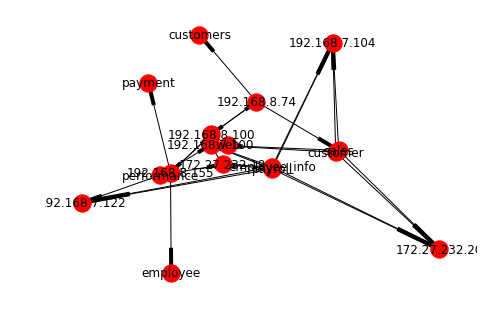

In [235]:
from_ = edges_final.select('from_id').rdd.map(lambda row: row[0]).collect()
to_ = edges_final.select('to_id').rdd.map(lambda row: row[0]).collect()

# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
df = pd.DataFrame({ 'from': from_, 'to': to_})
df
 
# Build your graph
G=nx.from_pandas_dataframe(df, 'from', 'to', create_using=nx.DiGraph())
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()


In [269]:
from py2neo import Graph

graph = Graph("http://192.168.7.143:7474/db/data/")

# merge nodes and relationship
# create Tom and Jerry as before
u1 = Node("Person",name='Tom',id=1)
u2 = Node('Person', name='Jerry', id=2)

# either use u1 and u2 directly
u1_knows_u2 = Relationship(u1, 'KKNOWS', u2)
graph.begin()

In [278]:
def importFromCSVtoNeo(graph):
    query = "MATCH (a {id: 21}),(b {id:14}) CREATE (a)-[r:tcp]->(b) RETURN a;"
    graph.run(query)
importFromCSVtoNeo(graph)

In [297]:
# this block get label information from http request
r = requests.get('http://192.168.7.143:8000/api/label/desc/')

# Currently this is HARD CODED
if read_label:
    label_map = {}
    for labeljson in r.json():
        apps = labeljson['address'].split(',')
        label_map[labeljson['roles']] = list(apps)
    label_map
label_map

{'admin': ['192.168.7.171', ' 192.168.7.130'],
 'recruiter': ['/cgi-bin/register.py', ' /cgi-bin/course.py'],
 'student': ['register', 'info'],
 'teacher': ['eval', ' course']}

In [ ]:
for new_ddn in label_map.keys():
    print(new_ddn)

In [ ]:
def label_ddn_edge_from_app(cur_ddn, application):
    for new_ddn in label_map.keys():
        app_list = label_map[new_ddn]
        if application in app_list:
            return new_ddn
    return cur_ddn
label_ddn_edge_from_app_udf = udf(label_ddn_edge_from_app, StringType())

In [ ]:
edges_labeled = edges.withColumn('ddn_id', 
                                 label_ddn_edge_from_app_udf('ddn_id', 
                                                             'application'))


In [ ]:
app_node_labeled = app_node.drop('ddn_id')\
                           .join(edges_labeled, app_node.node_id == edges_labeled.from_id, 'left_outer')\
                           .select(node_schema)
user_node_labeled = user_node.drop('ddn_id')\
                           .join(edges_labeled, user_node.node_id == edges_labeled.to_id, 'left_outer')\
                           .select(node_schema)
db_node_labeled = db_node.drop('ddn_id')\
                           .join(edges_labeled, db_node.node_id == edges_labeled.to_id, 'left_outer')\
                           .select(node_schema)

In [ ]:
node_labeled = app_node_labeled.union(user_node_labeled)\
                               .union(db_node_labeled)

In [ ]:
edges.show()